2025-08-29 14:21:23 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:21:23 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_4100183/3633611874.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Processing: pr_mean_annual_rmse


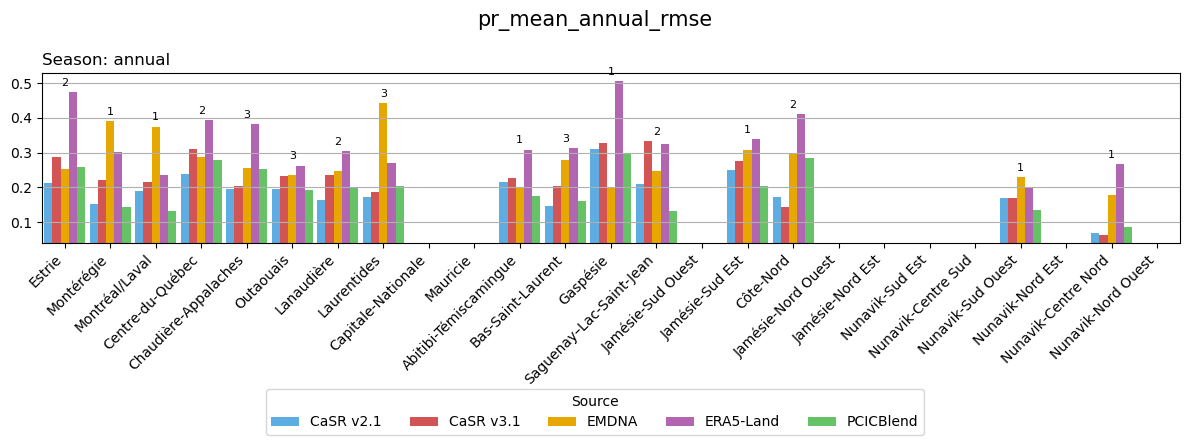

Processing: pr_mean_seasonal_rmse


/tmp/ipykernel_4100183/3633611874.py:97: RuntimeWarning: All-NaN axis encountered


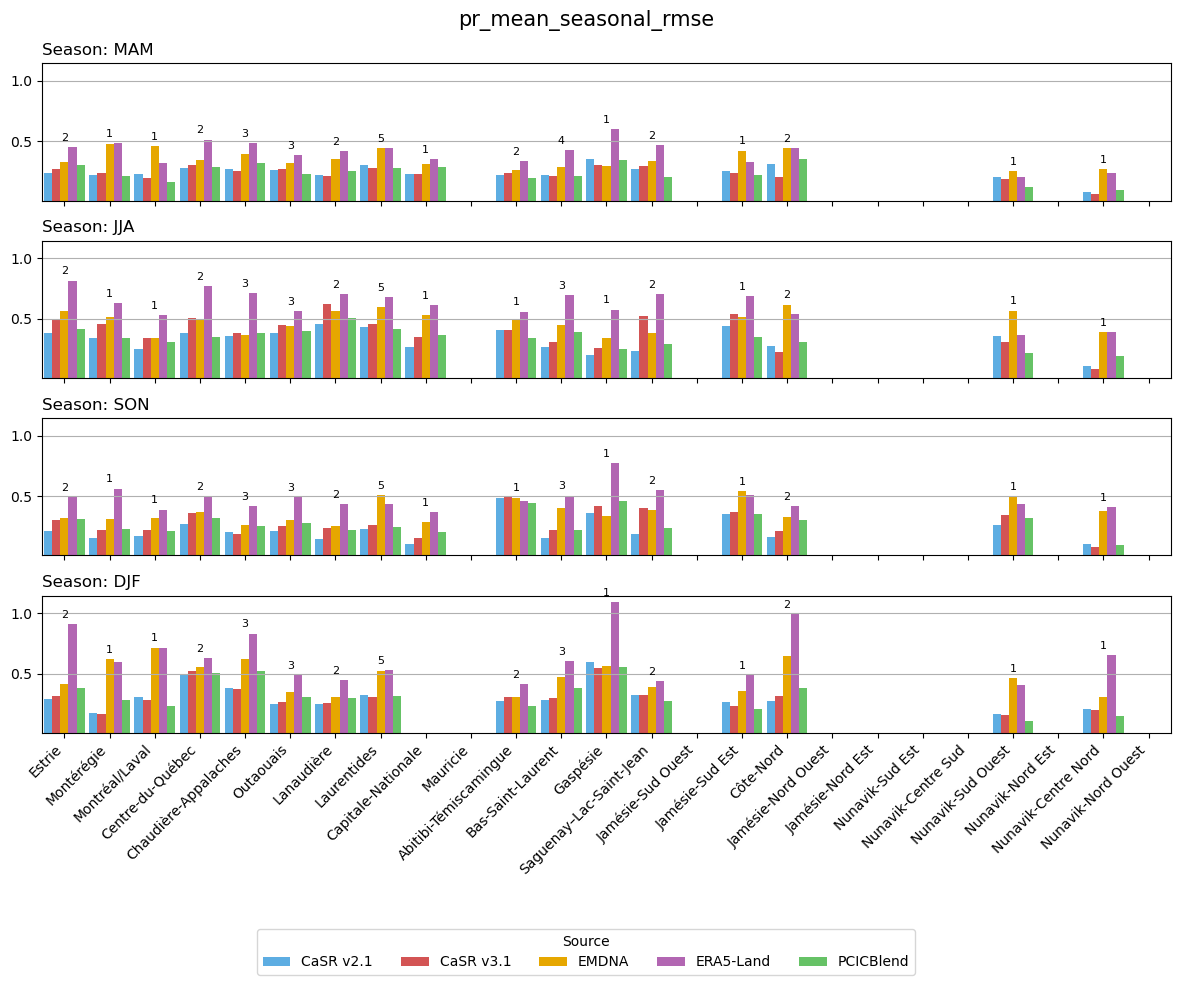

Processing: tg_mean_annual_rmse


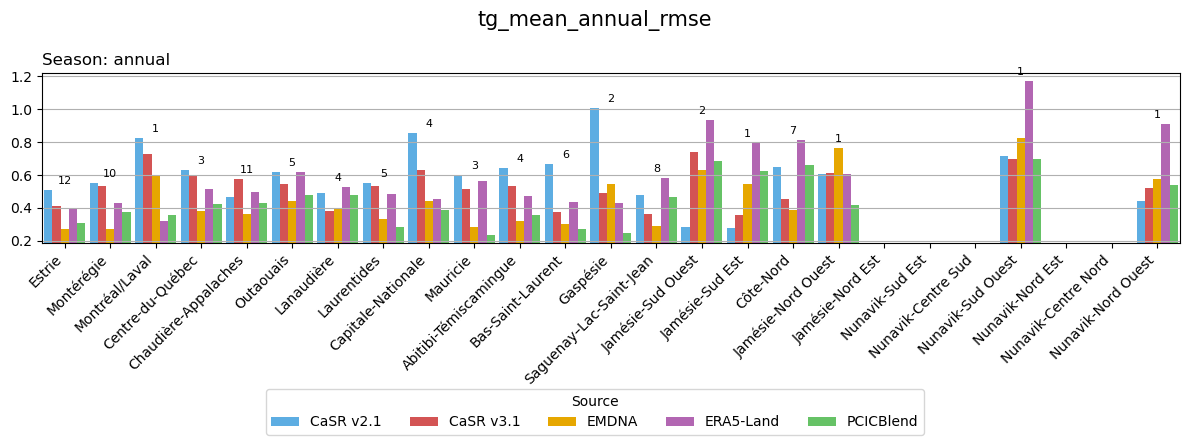

Processing: tg_mean_seasonal_rmse


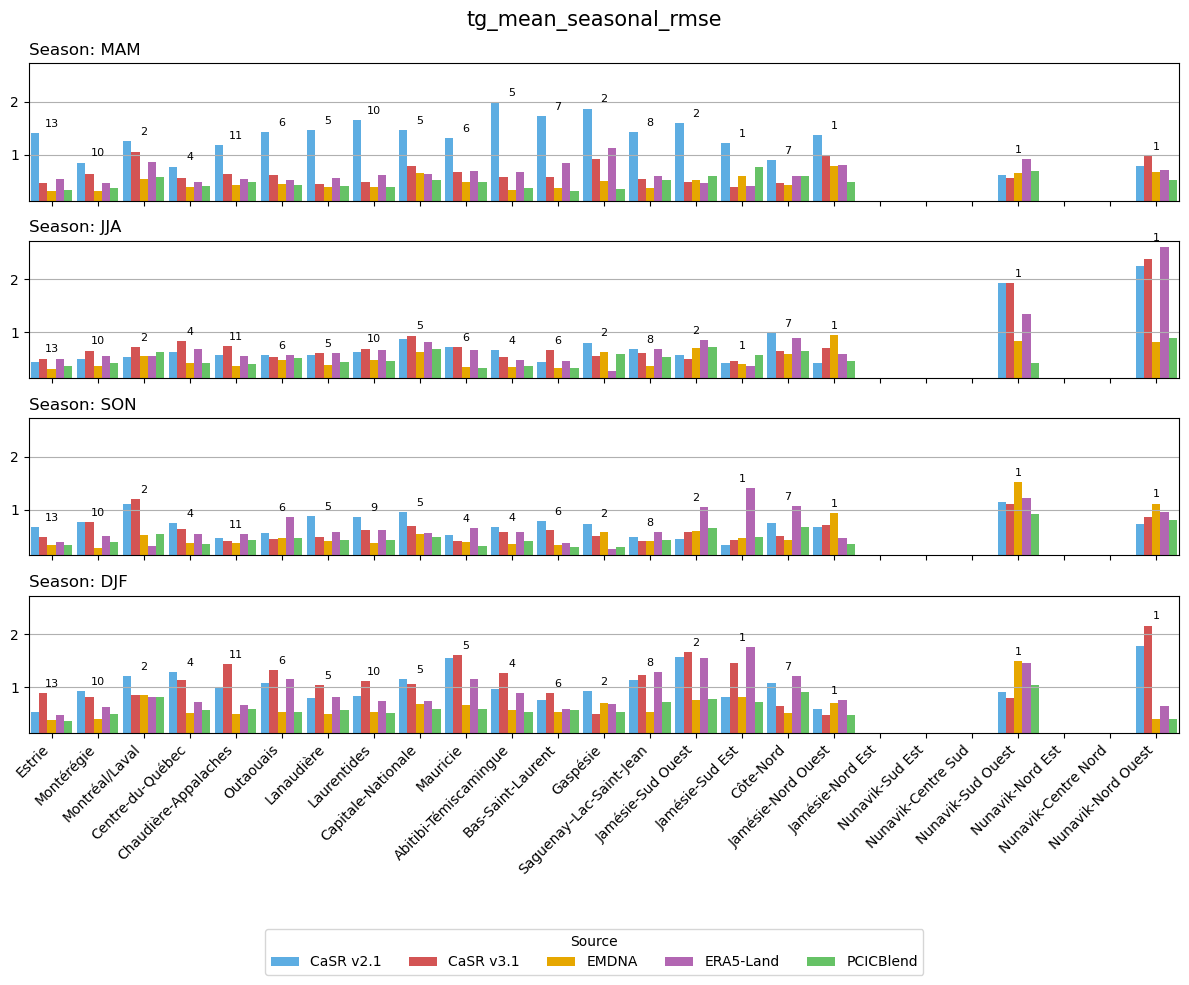

In [1]:
import xscen as xs
from xscen.config import CONFIG
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from plot_settings import SOURCE_COLORS, save_plot

import os
fig_path = CONFIG["paths"]["figures"]

# =========================
# Setup
# =========================
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# Load shapefile and compute centroids
gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid"] = gdf.geometry.centroid
gdf["centroid_x"] = gdf["centroid"].x
gdf["centroid_y"] = gdf["centroid"].y

# Sort regions south to north
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()

# Get list of regional_mean variables
df = pcat.df
df = df[df["processing_level"] == "regional_mean"]
variables = sorted({v for group in df["variable"].unique() for v in group})

# =========================
# Loop over variables
# =========================
for var in variables:
    print(f"Processing: {var}")
    try:
        ds_all = pcat.search(processing_level="regional_mean", variable=var).to_dataset().compute()
    except Exception as e:
        print(f"Failed to load dataset for {var}: {e}")
        continue

    if var not in ds_all:
        print(f"Variable '{var}' not found in dataset.")
        continue

    seasons = ds_all["season"].values
    n_rows = len(seasons)
    fig_height = 2.25 * n_rows if n_rows > 1 else 4
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=1,
        figsize=(12, fig_height),
        sharex=True
    )
    if n_rows == 1:
        axes = [axes]

    regions = REGION_ORDER
    sources = sorted(ds_all["source"].values.tolist())

    da_all = ds_all[var]
    ymin = float(da_all.min())
    ymax = float(da_all.max())
    y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
    bar_width = 0.9 / len(sources)

    for i, season in enumerate(seasons):
        ax = axes[i]
        ds = ds_all.sel(season=season)
        da = ds[var].reindex(region=regions)
        nstation_season = ds["nstation"].reindex(region=regions).values

        x = np.arange(len(regions))
        for j, source in enumerate(sources):
            y = da.sel(source=source).values
            color = SOURCE_COLORS.get(source, None)

            for k, (xpos, yval) in enumerate(zip(x, y)):
                bar_pos = xpos + j * bar_width - (len(sources) - 1) * bar_width / 2
                ax.bar(
                    bar_pos, yval,
                    width=bar_width,
                    color=color,
                    label=source if i == 0 and k == 0 else None
                )

        # Annotate station count once per region, above tallest bar
        for k, region_name in enumerate(regions):
            nst = nstation_season[k]
            if not np.isfinite(nst):
                continue
            region_vals = [
                da.sel(source=source).isel(region=k).item()
                for source in sources
            ]
            max_height = np.nanmax(region_vals)
            ax.annotate(
                f"{int(nst)}",
                xy=(x[k], max_height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8
            )

        ax.set_title(f"Season: {season}", loc='left')
        ax.set_ylim(ymin - y_pad, ymax + y_pad)
        ax.grid(True, axis='y')

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(regions, rotation=45, ha='right')
    axes[-1].set_xlim(-0.5, len(regions) - 0.5)

    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    fig.legend(uniq.values(), uniq.keys(), title="Source", loc='lower center',
               ncol=len(uniq), bbox_to_anchor=(0.5, -0.1))

    fig.suptitle(var, fontsize=15, y=0.98)
    fig.subplots_adjust(bottom=0.18, top=0.9)
    plt.tight_layout()
        
    save_plot(fig, processing_level="performance", horizon="1981-2010", freq="fx", file_name=f"{var}_bars")

    plt.show()


2025-08-29 14:21:28 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:21:28 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_4100183/4140169976.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Processing: pr_mean_annual_rmse


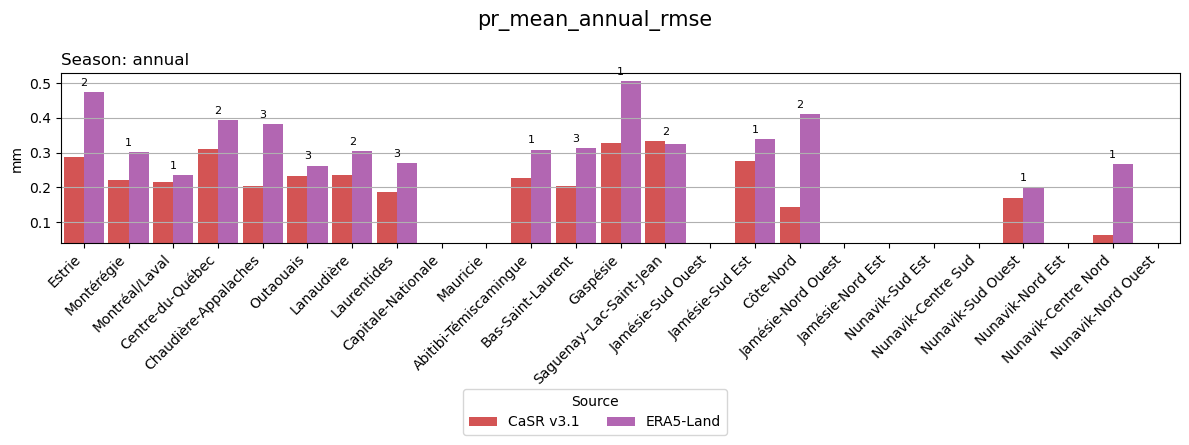

Processing: pr_mean_seasonal_rmse


/tmp/ipykernel_4100183/4140169976.py:99: RuntimeWarning: All-NaN axis encountered


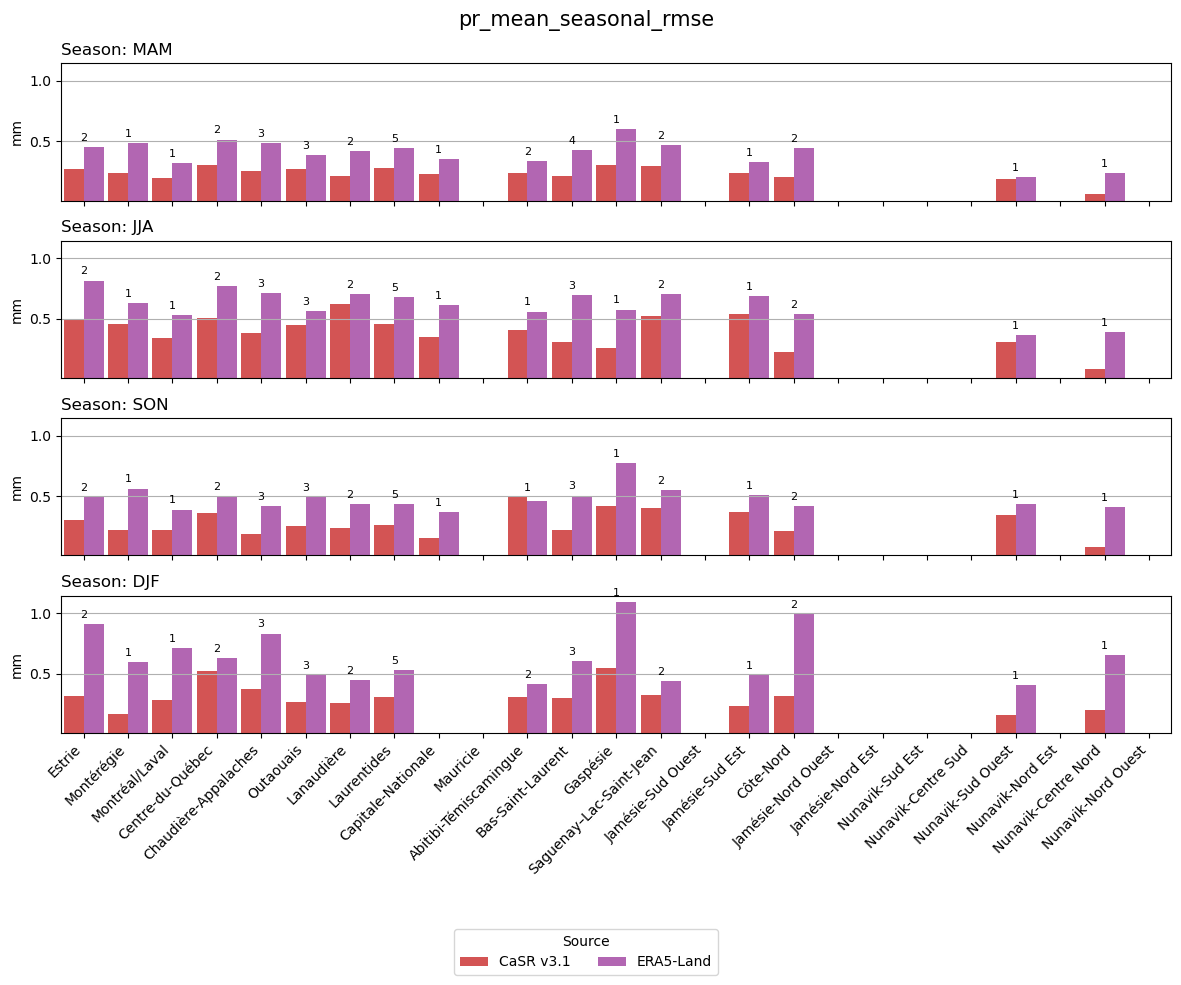

Processing: tg_mean_annual_rmse


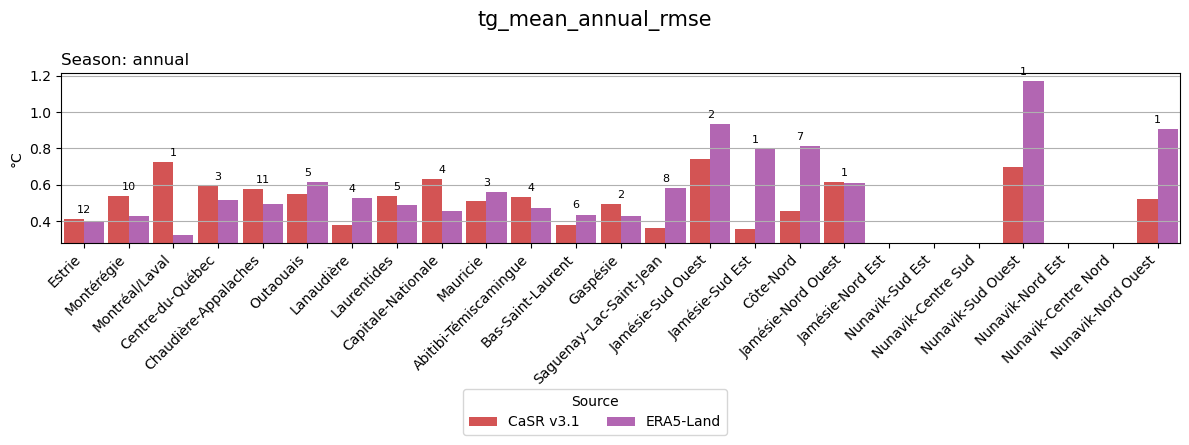

Processing: tg_mean_seasonal_rmse


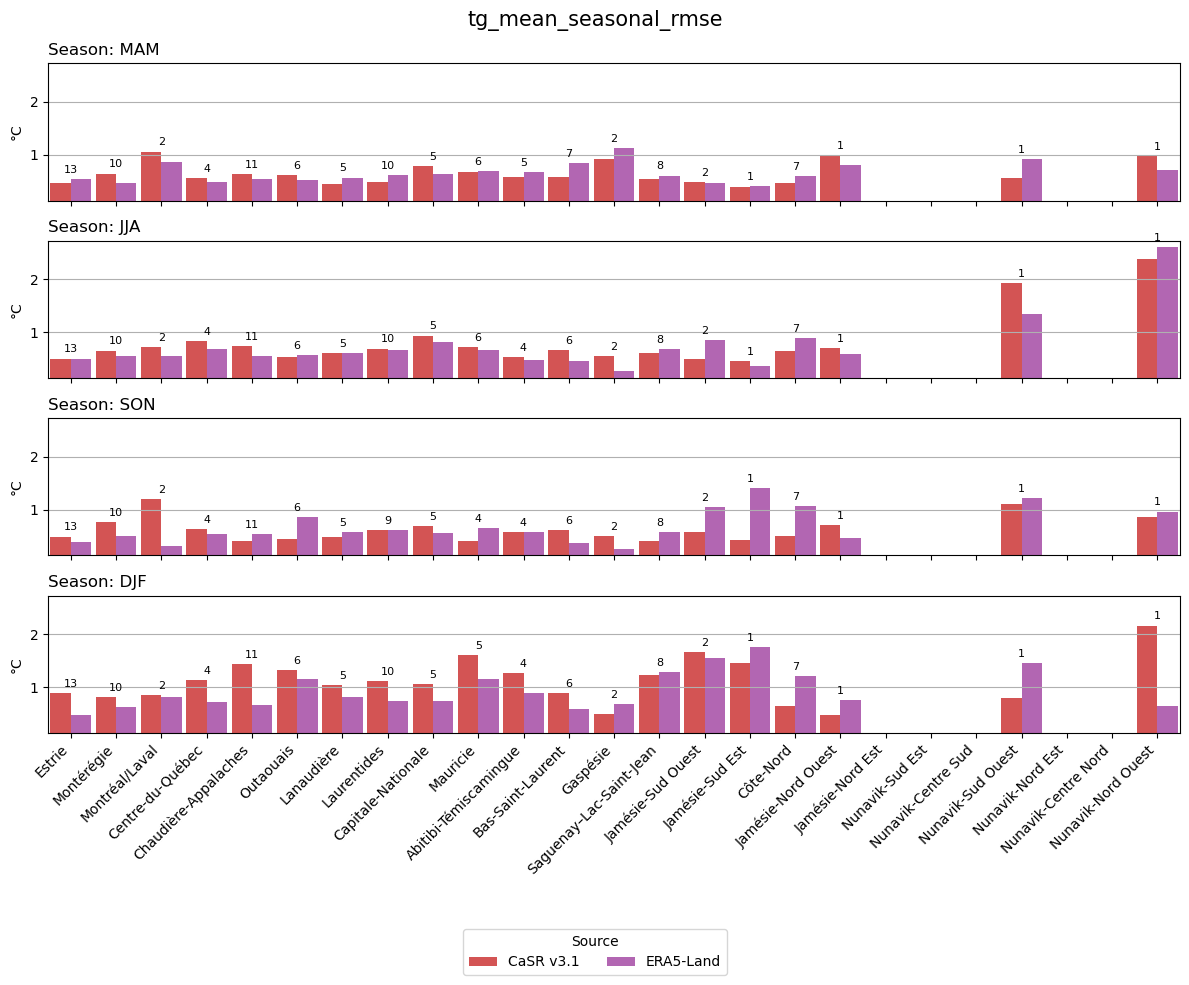

In [2]:
import xscen as xs
from xscen.config import CONFIG
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from plot_settings import SOURCE_COLORS, save_plot

import os
fig_path = CONFIG["paths"]["figures"]

# =========================
# Setup
# =========================
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# Load shapefile and compute centroids
gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid"] = gdf.geometry.centroid
gdf["centroid_x"] = gdf["centroid"].x
gdf["centroid_y"] = gdf["centroid"].y

# Sort regions south to north
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()

# Get list of regional_mean variables
df = pcat.df
df = df[df["processing_level"] == "regional_mean"]
variables = sorted({v for group in df["variable"].unique() for v in group})

# =========================
# Loop over variables
# =========================
for var in variables:
    print(f"Processing: {var}")
    try:
        ds_all = pcat.search(processing_level="regional_mean", variable=var).to_dataset().compute()
    except Exception as e:
        print(f"Failed to load dataset for {var}: {e}")
        continue

    if var not in ds_all:
        print(f"Variable '{var}' not found in dataset.")
        continue

    seasons = ds_all["season"].values
    n_rows = len(seasons)
    fig_height = 2.25 * n_rows if n_rows > 1 else 4
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=1,
        figsize=(12, fig_height),
        sharex=True
    )
    if n_rows == 1:
        axes = [axes]

    regions = REGION_ORDER
    sources = ["CaSR v3.1", "ERA5-Land"]
    ds_all = ds_all.sel(source=sources)

    da_all = ds_all[var]
    ymin = float(da_all.min())
    ymax = float(da_all.max())
    y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
    bar_width = 0.9 / len(sources)

    for i, season in enumerate(seasons):
        ax = axes[i]
        ds = ds_all.sel(season=season)
        da = ds[var].reindex(region=regions)
        nstation_season = ds["nstation"].reindex(region=regions).values

        x = np.arange(len(regions))
        for j, source in enumerate(sources):
            y = da.sel(source=source).values
            units = da.attrs["units"]
            color = SOURCE_COLORS.get(source, None)

            for k, (xpos, yval) in enumerate(zip(x, y)):
                bar_pos = xpos + j * bar_width - (len(sources) - 1) * bar_width / 2
                ax.bar(
                    bar_pos, yval,
                    width=bar_width,
                    color=color,
                    label=source if i == 0 and k == 0 else None
                )

        # Annotate station count once per region, above tallest bar
        for k, region_name in enumerate(regions):
            nst = nstation_season[k]
            if not np.isfinite(nst):
                continue
            region_vals = [
                da.sel(source=source).isel(region=k).item()
                for source in sources
            ]
            max_height = np.nanmax(region_vals)
            ax.annotate(
                f"{int(nst)}",
                xy=(x[k], max_height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8
            )

        ax.set_title(f"Season: {season}", loc='left')
        ax.set_ylim(ymin - y_pad, ymax + y_pad)
        ax.grid(True, axis='y')
        ax.set_ylabel(units)

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(regions, rotation=45, ha='right')
    axes[-1].set_xlim(-0.5, len(regions) - 0.5)

    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    fig.legend(uniq.values(), uniq.keys(), title="Source", loc='lower center',
               ncol=len(uniq), bbox_to_anchor=(0.5, -0.1))

    fig.suptitle(var, fontsize=15, y=0.98)
    fig.subplots_adjust(bottom=0.18, top=0.9)
    plt.tight_layout()
        
    save_plot(fig, processing_level="performance", horizon="1981-2010", freq="fx", file_name=f"{var}_bars_CaSR v3.1_vs_ERA5-Land")

    plt.show()


2025-08-29 14:21:31 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 14:21:31 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_4100183/512564114.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Processing: pr_mean_annual_rmse


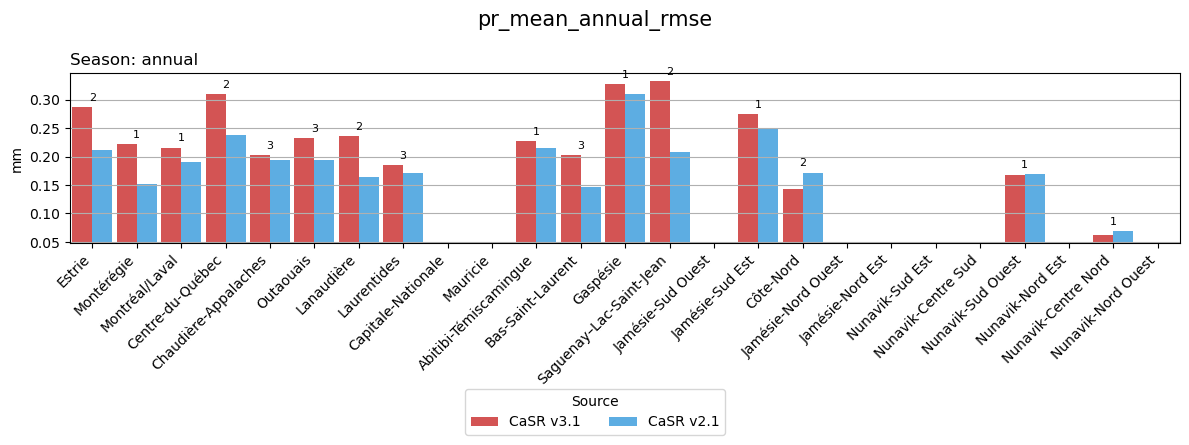

Processing: pr_mean_seasonal_rmse


/tmp/ipykernel_4100183/512564114.py:99: RuntimeWarning: All-NaN axis encountered


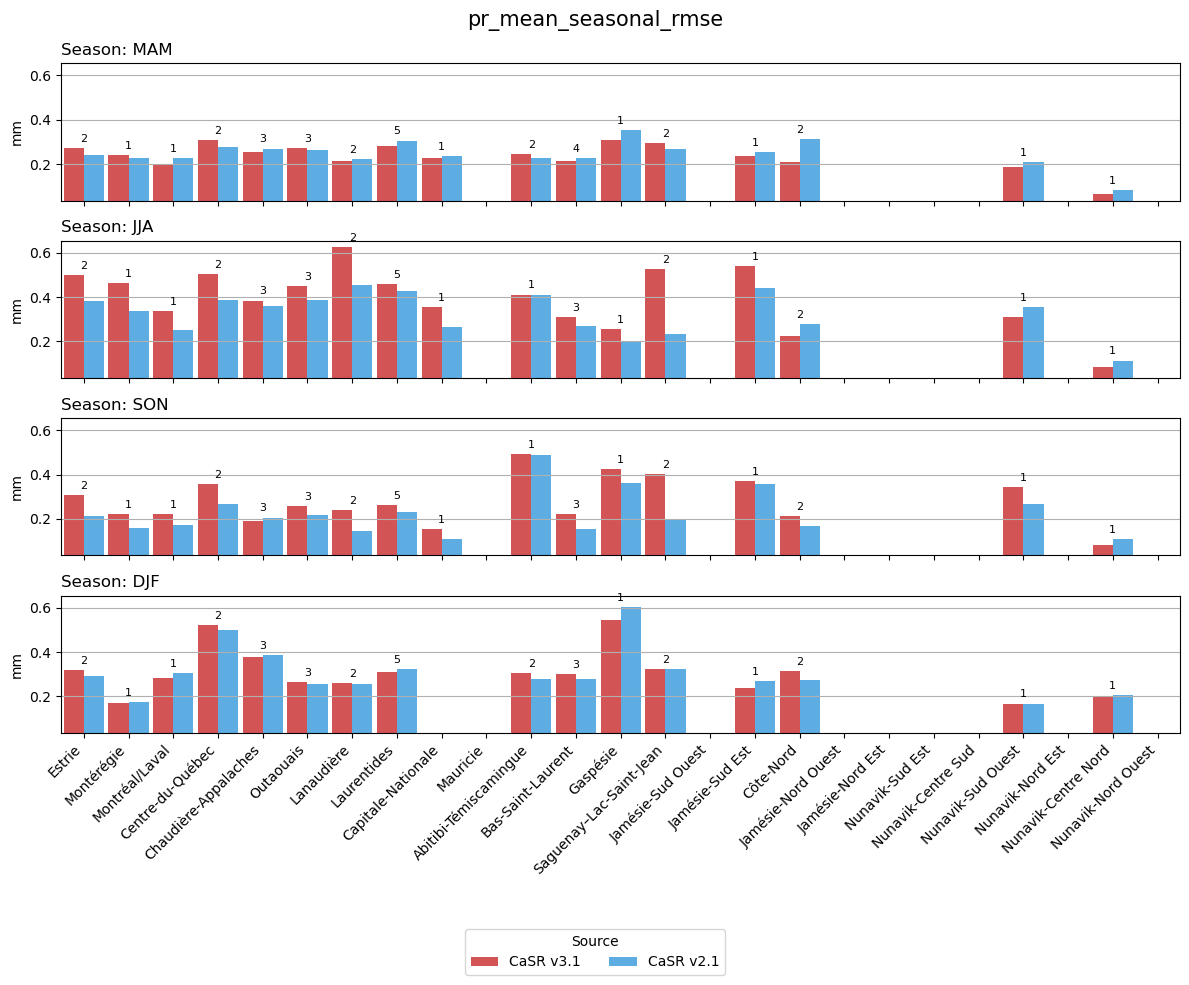

Processing: tg_mean_annual_rmse


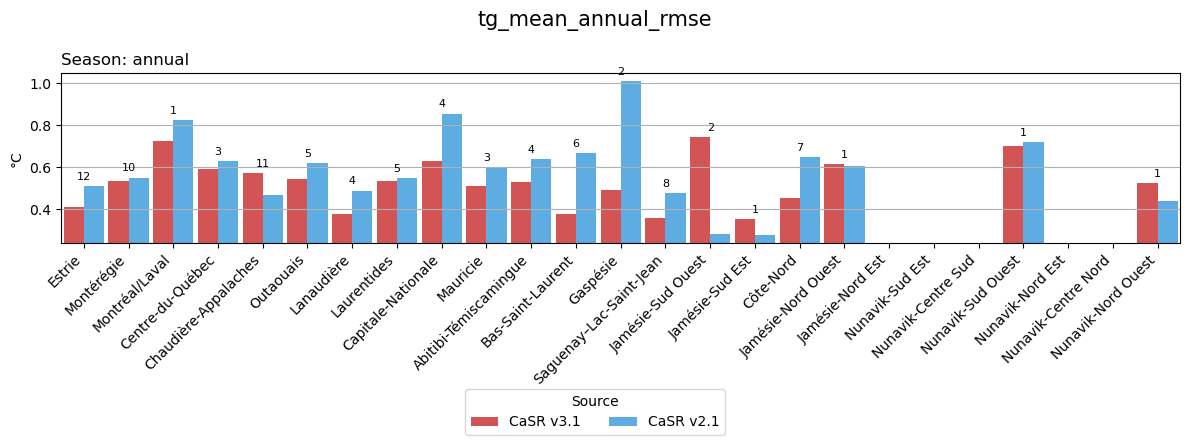

Processing: tg_mean_seasonal_rmse


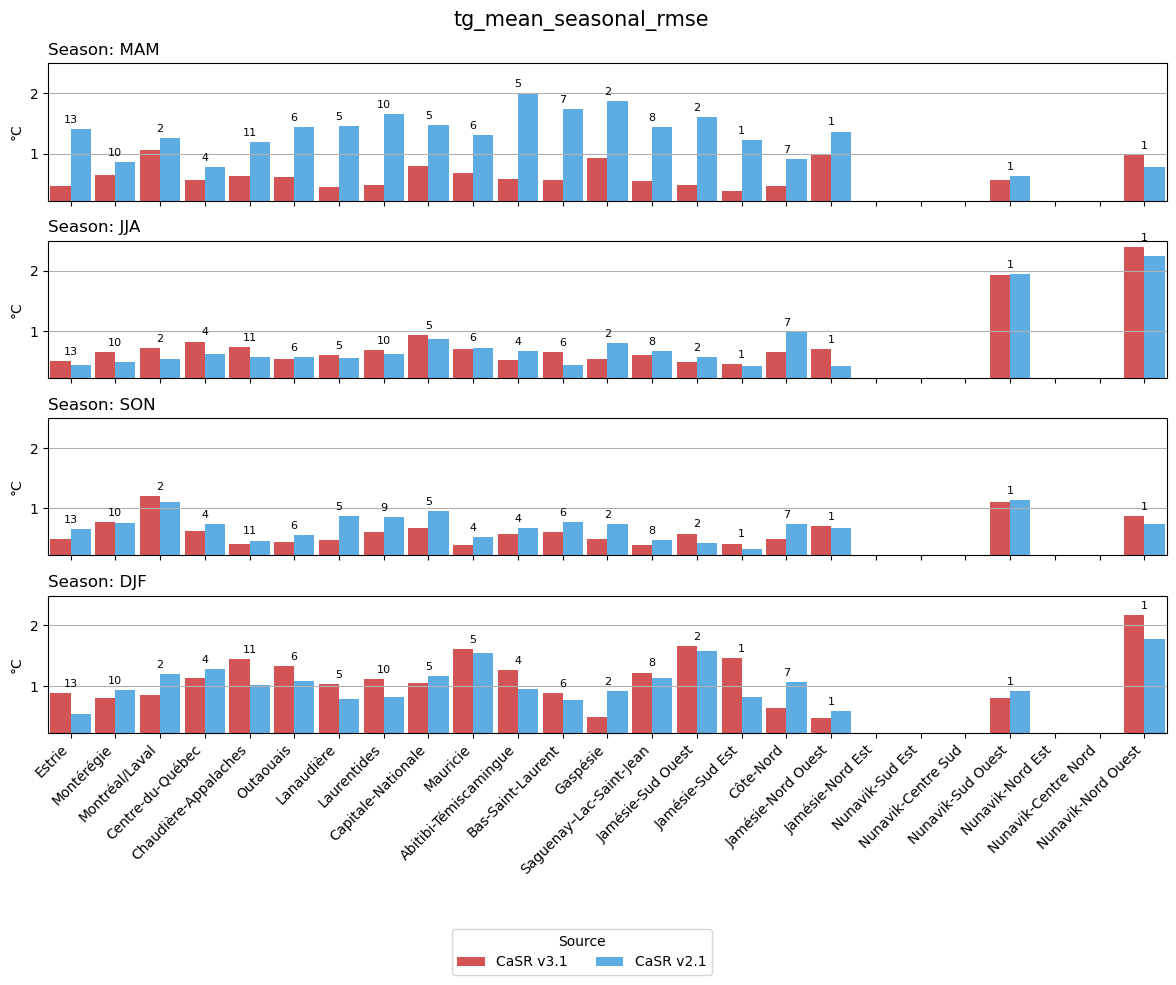

In [3]:
import xscen as xs
from xscen.config import CONFIG
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from plot_settings import SOURCE_COLORS, save_plot

import os
fig_path = CONFIG["paths"]["figures"]

# =========================
# Setup
# =========================
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# Load shapefile and compute centroids
gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid"] = gdf.geometry.centroid
gdf["centroid_x"] = gdf["centroid"].x
gdf["centroid_y"] = gdf["centroid"].y

# Sort regions south to north
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()

# Get list of regional_mean variables
df = pcat.df
df = df[df["processing_level"] == "regional_mean"]
variables = sorted({v for group in df["variable"].unique() for v in group})

# =========================
# Loop over variables
# =========================
for var in variables:
    print(f"Processing: {var}")
    try:
        ds_all = pcat.search(processing_level="regional_mean", variable=var).to_dataset().compute()
    except Exception as e:
        print(f"Failed to load dataset for {var}: {e}")
        continue

    if var not in ds_all:
        print(f"Variable '{var}' not found in dataset.")
        continue

    seasons = ds_all["season"].values
    n_rows = len(seasons)
    fig_height = 2.25 * n_rows if n_rows > 1 else 4
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=1,
        figsize=(12, fig_height),
        sharex=True
    )
    if n_rows == 1:
        axes = [axes]

    regions = REGION_ORDER
    sources = ["CaSR v3.1", "CaSR v2.1"]
    ds_all = ds_all.sel(source=sources)

    da_all = ds_all[var]
    ymin = float(da_all.min())
    ymax = float(da_all.max())
    y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
    bar_width = 0.9 / len(sources)

    for i, season in enumerate(seasons):
        ax = axes[i]
        ds = ds_all.sel(season=season)
        da = ds[var].reindex(region=regions)
        nstation_season = ds["nstation"].reindex(region=regions).values

        x = np.arange(len(regions))
        for j, source in enumerate(sources):
            y = da.sel(source=source).values
            units = da.attrs["units"]
            color = SOURCE_COLORS.get(source, None)

            for k, (xpos, yval) in enumerate(zip(x, y)):
                bar_pos = xpos + j * bar_width - (len(sources) - 1) * bar_width / 2
                ax.bar(
                    bar_pos, yval,
                    width=bar_width,
                    color=color,
                    label=source if i == 0 and k == 0 else None
                )

        # Annotate station count once per region, above tallest bar
        for k, region_name in enumerate(regions):
            nst = nstation_season[k]
            if not np.isfinite(nst):
                continue
            region_vals = [
                da.sel(source=source).isel(region=k).item()
                for source in sources
            ]
            max_height = np.nanmax(region_vals)
            ax.annotate(
                f"{int(nst)}",
                xy=(x[k], max_height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8
            )

        ax.set_title(f"Season: {season}", loc='left')
        ax.set_ylim(ymin - y_pad, ymax + y_pad)
        ax.grid(True, axis='y')
        ax.set_ylabel(units)

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(regions, rotation=45, ha='right')
    axes[-1].set_xlim(-0.5, len(regions) - 0.5)

    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    fig.legend(uniq.values(), uniq.keys(), title="Source", loc='lower center',
               ncol=len(uniq), bbox_to_anchor=(0.5, -0.1))

    fig.suptitle(var, fontsize=15, y=0.98)
    fig.subplots_adjust(bottom=0.18, top=0.9)
    plt.tight_layout()
        
    save_plot(fig, processing_level="performance", horizon="1981-2010", freq="fx", file_name=f"{var}_bars_CaSR v3.1_vs_CaSR v2.1")

    plt.show()
